# Using the Pandas Python Data Toolkit

Today we will highlight some very useful and cool features of the Pandas library in Python while playing with some nematode worm behaviour data collected from the multi-worm-tracker (Swierczek et al., 2011).  

Specifically, we will explore:
    1. Loading data
    2. Dataframe data structures
    3. Element-wise mathematics
    4. Working with time series data
    5. Groupby operations
    6. Quick and easy visualization

## Some initial setup

In [6]:
## load libraries
%matplotlib inline
import pandas as pd
import numpy as np

from pandas import set_option
set_option("display.max_rows", 4)

## magic to time cells in ipython notebook
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

Installed autotime.py. To use it, type:
  %load_ext autotime
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.86 s


## 1. Loading data from a local text file

More details, see http://pandas.pydata.org/pandas-docs/stable/io.html

Let's first load some behaviour data from a collection of wild-type worms.

In [36]:
filename = 'data/behav_2.dat'
behav = pd.read_table(filename, sep = '\s+')
behav

date            plate     time     strain  frame  ID  persistance  \
0       20141118  20141118_131037   15.028  wild-type      0   1        234.9   
1       20141118  20141118_131037   15.069  wild-type      1   1        234.9   
...          ...              ...      ...        ...    ...  ..          ...   
507152  20141118  20141118_133214  249.938   mutant_1   5840  87         24.3   
507153  20141118  20141118_133214  249.977   mutant_1   5841  87         24.3   

            area  speed  angularspeed  ...   bias  pathlen  curve  dir  \
0       0.096228    NaN           NaN  ...      1    0.000   38.2    0   
1       0.096957    NaN           NaN  ...      1    0.010   32.7    0   
...          ...    ...           ...  ...    ...      ...    ...  ...   
507152  0.106434    NaN           NaN  ...      0    2.941   23.6    0   
507153  0.107163    NaN           NaN  ...      0    2.941   23.7    0   

          loc_x    loc_y  vel_x  vel_y  orient  crab  
0       29.0036  29.4805    NaN    NaN   103.3   NaN  
1       29.0076  29.4713    NaN    NaN   103.1   NaN  
...         ...      ...    ...    ...     ...   ...  
507152  35.8461  22.6167    NaN    NaN   139.7   NaN  
507153  35.8462  22.6168    NaN    NaN   139.8   NaN  

[507154 rows x 29 columns]

time: 3.56 s


## 2. Dataframe data structures

For more details, see http://pandas.pydata.org/pandas-docs/stable/dsintro.html

Pandas provides access to data frame data structures. These tabular data objects allow you to mix and match arrays of different data types in one "table".

In [37]:
print(behav.dtypes)

date        int64
plate      object
           ...   
orient    float64
crab      float64
dtype: object
time: 4.65 ms


## 3. Accessing data in a Pandas dataframe

How to you access data in Pandas? There are at least two ways, the first uses column names and is very similar to how this is done in R, and the second uses the attribute `.iloc` which allows you to slice similar to lists and numpy.

Here is how to access a column, for example the speed column:

In [38]:
behav['morphwidth']

0         0.0897
1         0.0872
           ...  
507152    0.1096
507153    0.1106
Name: morphwidth, dtype: float64

time: 46.1 ms


When we access only a single column in pandas, it is no longer of type dataframe, but of type series:

In [39]:
type(behav['morphwidth'])

pandas.core.series.Series

time: 2.51 ms


To access multiple columns this way we would do the following:

In [40]:
behav[['strain', 'morphwidth']]

strain  morphwidth
0       wild-type      0.0897
1       wild-type      0.0872
...           ...         ...
507152   mutant_1      0.1096
507153   mutant_1      0.1106

[507154 rows x 2 columns]

time: 21.8 ms


You can use this notation to apply functions to certain columns, for example, how many unique values in strain are there?

In [41]:
set(behav['strain'])

{'mutant_1', 'wild-type'}

time: 25.9 ms


In certain situations you may want to index via column number, you can do this as follows:

In [43]:
# access the 3rd column called strain
behav.iloc[:,3]

0         wild-type
1         wild-type
            ...    
507152     mutant_1
507153     mutant_1
Name: strain, dtype: object

time: 5.82 ms


You can use this to access only a subset of the rows as well, for example the first 10 rows for columns 2 & 3: 

In [45]:
behav.iloc[:10,2:4]

time     strain
0   15.028  wild-type
1   15.069  wild-type
..     ...        ...
8   15.350  wild-type
9   15.387  wild-type

[10 rows x 2 columns]

time: 26.9 ms


## 4. Element-wise mathematics

Suppose we want to add a new column that is a combination of two columns in our dataset. Similar to `numpy`, `Pandas` lets us do this easily and deals with doing math between columns on an element by element basis. For example, We are interested in the ratio of the midline length divided by the morphwidth to look at whether worms are crawling in a straight line or curling back on themselves (*e.g.,* during a turn).

In [20]:
## vectorization takes 49.3 ms
behav['mid_width_ratio'] = behav['morphwidth']/behav['midline']
behav[['morphwidth', 'midline', 'mid_width_ratio']].head()

morphwidth  midline  mid_width_ratio
0            1     12.1         0.082645
1            1      5.9         0.169492
..         ...      ...              ...
3            1     14.9         0.067114
4            1      6.3         0.158730

[5 rows x 3 columns]

time: 59.8 ms


In [ ]:
## looping takes 1 min 44s
mid_width_ratio = np.empty(len(behav['morphwidth']), dtype='float64')

for i in range(1,len(behav['morphwidth'])):
    mid_width_ratio[i] =+ behav.loc[i,'morphwidth']/behav.loc[i,'midline']
    
behav['mid_width_ratio'] = mid_width_ratio
behav[['morphwidth', 'midline', 'mid_width_ratio']].head()

### `apply()`
For more details, see: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html

Another bonus about using Pandas is the `apply` function - this allows you to apply any function to a select column(s) or row(s) of a dataframe, or accross the entire dataframe.

In [21]:
## custom function to center data
def center(data):
    return data - data.mean()

time: 2.52 ms


In [22]:
## center all data on a column basis
behav.iloc[:,4:].apply(center).head()

area     speed  angular_speed    aspect    midline  morphwidth  \
0  -0.002280  0.249039      -6.313001 -0.219804  11.004384    0.904059   
1  -0.002280  0.249039      -6.320601 -0.220104   4.804384    0.904059   
..       ...       ...            ...       ...        ...         ...   
3  -0.000093  0.229039      -6.279701 -0.220304  13.804384    0.904059   
4   0.000636  0.221039      -6.257501 -0.217504   5.204384    0.904059   

         kink  bias  pathlength  mid_width_ratio  
0  -43.962917   NaN         NaN        -0.029877  
1  -43.955917   NaN         NaN         0.056970  
..        ...   ...         ...              ...  
3  -43.942917   NaN         NaN        -0.045408  
4  -43.935917   NaN         NaN         0.046208  

[5 rows x 10 columns]

time: 58.4 ms


## 5. Working with time series data

### Indices
For more details, see http://pandas.pydata.org/pandas-docs/stable/indexing.html

Given that this is time series data we will want to set the index to time, we can do this while we read in the data.

In [57]:
behav = pd.read_table(filename, sep = '\s+', index_col='time')
behav

date            plate     strain  frame  ID  persistance  \
time                                                                    
15.028   20141118  20141118_131037  wild-type      0   1        234.9   
15.069   20141118  20141118_131037  wild-type      1   1        234.9   
...           ...              ...        ...    ...  ..          ...   
249.938  20141118  20141118_133214   mutant_1   5840  87         24.3   
249.977  20141118  20141118_133214   mutant_1   5841  87         24.3   

             area  speed  angularspeed  length  ...   bias  pathlen  curve  \
time                                            ...                          
15.028   0.096228    NaN           NaN  0.7560  ...      1    0.000   38.2   
15.069   0.096957    NaN           NaN  0.7803  ...      1    0.010   32.7   
...           ...    ...           ...     ...  ...    ...      ...    ...   
249.938  0.106434    NaN           NaN  0.9153  ...      0    2.941   23.6   
249.977  0.107163    NaN           NaN  0.9153  ...      0    2.941   23.7   

         dir    loc_x    loc_y  vel_x  vel_y  orient  crab  
time                                                        
15.028     0  29.0036  29.4805    NaN    NaN   103.3   NaN  
15.069     0  29.0076  29.4713    NaN    NaN   103.1   NaN  
...      ...      ...      ...    ...    ...     ...   ...  
249.938    0  35.8461  22.6167    NaN    NaN   139.7   NaN  
249.977    0  35.8462  22.6168    NaN    NaN   139.8   NaN  

[507154 rows x 28 columns]

time: 3.78 s


To utilize functions built into Pandas to deal with time series data, let's convert our
time to a date time object using the `to_datetime()` function.

In [58]:
behav.index.dtype

dtype('float64')

time: 2.24 ms


In [60]:
behav.index = pd.to_datetime(behav.index, unit='s')
print(behav.index.dtype)

datetime64[ns]
time: 714 ms


In [61]:
behav

date            plate     strain  frame  ID  \
1970-01-01 00:00:15.028  20141118  20141118_131037  wild-type      0   1   
1970-01-01 00:00:15.069  20141118  20141118_131037  wild-type      1   1   
...                           ...              ...        ...    ...  ..   
1970-01-01 00:04:09.938  20141118  20141118_133214   mutant_1   5840  87   
1970-01-01 00:04:09.977  20141118  20141118_133214   mutant_1   5841  87   

                         persistance      area  speed  angularspeed  length  \
1970-01-01 00:00:15.028        234.9  0.096228    NaN           NaN  0.7560   
1970-01-01 00:00:15.069        234.9  0.096957    NaN           NaN  0.7803   
...                              ...       ...    ...           ...     ...   
1970-01-01 00:04:09.938         24.3  0.106434    NaN           NaN  0.9153   
1970-01-01 00:04:09.977         24.3  0.107163    NaN           NaN  0.9153   

                         ...   bias  pathlen  curve  dir    loc_x    loc_y  \
1970-01-01 00:00:15.028  ...      1    0.000   38.2    0  29.0036  29.4805   
1970-01-01 00:00:15.069  ...      1    0.010   32.7    0  29.0076  29.4713   
...                      ...    ...      ...    ...  ...      ...      ...   
1970-01-01 00:04:09.938  ...      0    2.941   23.6    0  35.8461  22.6167   
1970-01-01 00:04:09.977  ...      0    2.941   23.7    0  35.8462  22.6168   

                         vel_x  vel_y  orient  crab  
1970-01-01 00:00:15.028    NaN    NaN   103.3   NaN  
1970-01-01 00:00:15.069    NaN    NaN   103.1   NaN  
...                        ...    ...     ...   ...  
1970-01-01 00:04:09.938    NaN    NaN   139.7   NaN  
1970-01-01 00:04:09.977    NaN    NaN   139.8   NaN  

[507154 rows x 28 columns]

time: 250 ms


Now that our index is of datetime object, we can use the resample function to get time intervals. With this function you can choose the time interval as well as how to downsample (mean, sum, *etc.*)

In [62]:
behav_resampled = behav.resample('10s', how=('mean'))
behav_resampled

date        frame          ID  persistance      area  \
1970-01-01 00:00:10  20141118    62.711085   13.864025   155.839342  0.089762   
1970-01-01 00:00:20  20141118   249.180675   15.628123   153.852831  0.090508   
...                       ...          ...         ...          ...       ...   
1970-01-01 00:03:50  20141118  5458.693863  177.873863   150.224391  0.094090   
1970-01-01 00:04:00  20141118  5704.926108  175.989060   151.687085  0.093545   

                        speed  angularspeed    length  rellength     width  \
1970-01-01 00:00:10  0.164503      8.433122  0.780019   1.014002  0.197847   
1970-01-01 00:00:20  0.155679      7.205397  0.792260   1.026839  0.192063   
...                       ...           ...       ...        ...       ...   
1970-01-01 00:03:50  0.109268      4.521180  0.819377   1.047367  0.176305   
1970-01-01 00:04:00  0.102982      4.329094  0.814193   1.038616  0.175390   

                       ...         bias   pathlen      curve       dir  \
1970-01-01 00:00:10    ...     0.952569  0.389527  28.552254  0.000624   
1970-01-01 00:00:20    ...     0.876174  1.423877  28.563552  0.002201   
...                    ...          ...       ...        ...       ...   
1970-01-01 00:03:50    ...     0.908607  7.674139  24.975206  0.001973   
1970-01-01 00:04:00    ...     0.829332  8.742751  24.785606  0.002309   

                         loc_x      loc_y     vel_x     vel_y     orient  \
1970-01-01 00:00:10  23.978876  23.584906  0.012174 -0.024756  47.414245   
1970-01-01 00:00:20  24.041254  23.072667  0.022262 -0.006205  41.538622   
...                        ...        ...       ...       ...        ...   
1970-01-01 00:03:50  24.506425  24.095993  0.002343  0.013047  12.485120   
1970-01-01 00:04:00  24.863789  24.863597  0.004902  0.012062   3.551655   

                         crab  
1970-01-01 00:00:10  0.013190  
1970-01-01 00:00:20  0.011724  
...                       ...  
1970-01-01 00:03:50  0.006728  
1970-01-01 00:04:00  0.006358  

[24 rows x 26 columns]

time: 476 ms


This has reduced our dataset to a more manageable size, **but** we have lost the column `strain` because resample just combined all rows for every 10s. This is not exactly what we want to do because we want to compare these groups... We need to use another pandas function, `groupby` to allow us to keep this information.

## 6. Groupby operations

In this dataset we have 2 different worm strains, or groups. When it comes to analysis and/or plotting we likely want to act on these groups each independently. We can use the pandas `groupby()` function to help us do this:

In [63]:
# make a groupby object which groups by strains
grouped_behav = behav.groupby('strain')
type(grouped_behav)

pandas.core.groupby.DataFrameGroupBy

time: 2.95 ms


In [64]:
print(grouped_behav)

time: 1.53 ms


You can see that the groupby object we created isn't very useful on its own, but we can use it when we are acting on the dataframe to make sure the functions/methods we apply act on the groups, not the whole dataframe.

For example, if we now want to resample each group separately so we do not lose the strain information we can do the following:

In [66]:
resampled_groups = behav.groupby('strain').resample('10s', how=('mean'))
resampled_groups

ID  angularspeed      area    aspect  \
strain                                                                        
mutant_1  1970-01-01 00:00:10   14.166029      5.341250  0.084776  0.213143   
          1970-01-01 00:00:20   15.551754      5.557723  0.085505  0.218023   
...                                   ...           ...       ...       ...   
wild-type 1970-01-01 00:03:50  288.899770      5.980102  0.098288  0.248843   
          1970-01-01 00:04:00  287.499373      5.582613  0.098004  0.246534   

                                   bias      crab      curve      date  \
strain                                                                   
mutant_1  1970-01-01 00:00:10  0.944940  0.010161  25.515777  20141118   
          1970-01-01 00:00:20  0.887064  0.010114  26.195024  20141118   
...                                 ...       ...        ...       ...   
wild-type 1970-01-01 00:03:50  0.937489  0.008730  27.963539  20141118   
          1970-01-01 00:04:00  0.875750  0.008100  27.132316  20141118   

                                    dir        frame    ...        orient  \
strain                                                  ...                 
mutant_1  1970-01-01 00:00:10  0.000083    62.651573    ...     57.650553   
          1970-01-01 00:00:20  0.002584   248.706677    ...     50.283069   
...                                 ...          ...    ...           ...   
wild-type 1970-01-01 00:03:50  0.001735  5453.795268    ...      8.020835   
          1970-01-01 00:04:00  0.001426  5699.430874    ...     -5.885441   

                                pathlen  persistance  relaspect  rellength  \
strain                                                                       
mutant_1  1970-01-01 00:00:10  0.386367   162.409864   0.893754   1.029213   
          1970-01-01 00:00:20  1.433472   163.010681   0.907928   1.021623   
...                                 ...          ...        ...        ...   
wild-type 1970-01-01 00:03:50  7.559928   117.936149   0.942490   1.035555   
          1970-01-01 00:04:00  9.190967   119.019323   0.942170   1.026389   

                               relwidth     speed     vel_x     vel_y  \
strain                                                                  
mutant_1  1970-01-01 00:00:10  0.961974  0.163496 -0.008042 -0.023233   
          1970-01-01 00:00:20  0.970967  0.155818  0.002565 -0.014216   
...                                 ...       ...       ...       ...   
wild-type 1970-01-01 00:03:50  0.994018  0.125332  0.013883  0.025775   
          1970-01-01 00:04:00  0.982084  0.120613  0.014010  0.022929   

                                  width  
strain                                   
mutant_1  1970-01-01 00:00:10  0.167119  
          1970-01-01 00:00:20  0.169132  
...                                 ...  
wild-type 1970-01-01 00:03:50  0.200221  
          1970-01-01 00:04:00  0.197696  

[48 rows x 26 columns]

time: 643 ms


## 7. Quick and easy visualization
For more details, see: http://pandas.pydata.org/pandas-docs/version/0.15.0/visualization.html

To plot any of our columns with numerical measurements against time, we can use pandas built-in plot function:

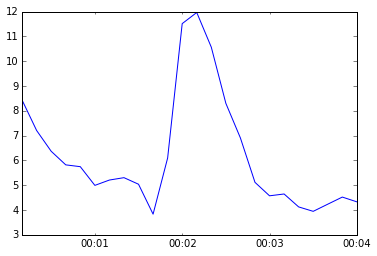

time: 194 ms


In [72]:
behav_resampled['angularspeed'].plot()

You can plot all of the columns:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x114db0ac8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1164c2ba8>], dtype=object)

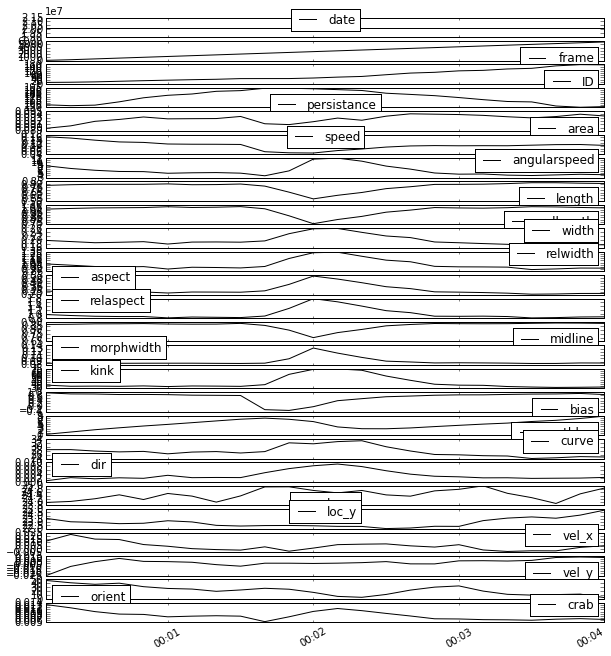

time: 5.03 s


In [73]:
behav_resampled.plot(subplots=True, figsize = (10, 12))

Or you can also plot a subset of the columns:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11671a6a0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11cf8be48>], dtype=object)

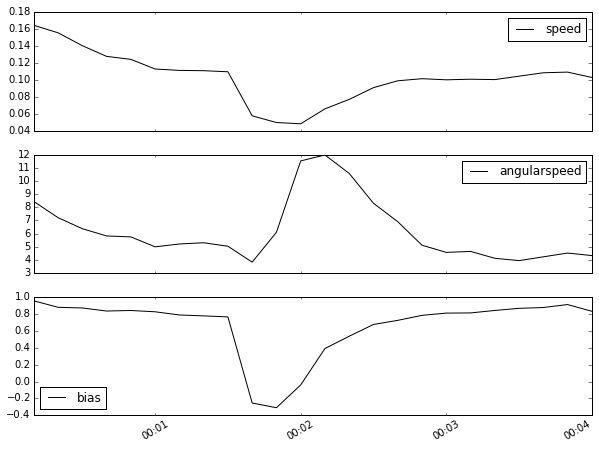

time: 569 ms


In [75]:
behav_resampled[['speed', 'angularspeed', 'bias']].plot(subplots = True, figsize = (10,8))

But notice we have been working with the ungrouped dataframe, can we do this with our grouped dataframe?

In [76]:
resampled_groups

ID  angularspeed      area    aspect  \
strain                                                                        
mutant_1  1970-01-01 00:00:10   14.166029      5.341250  0.084776  0.213143   
          1970-01-01 00:00:20   15.551754      5.557723  0.085505  0.218023   
...                                   ...           ...       ...       ...   
wild-type 1970-01-01 00:03:50  288.899770      5.980102  0.098288  0.248843   
          1970-01-01 00:04:00  287.499373      5.582613  0.098004  0.246534   

                                   bias      crab      curve      date  \
strain                                                                   
mutant_1  1970-01-01 00:00:10  0.944940  0.010161  25.515777  20141118   
          1970-01-01 00:00:20  0.887064  0.010114  26.195024  20141118   
...                                 ...       ...        ...       ...   
wild-type 1970-01-01 00:03:50  0.937489  0.008730  27.963539  20141118   
          1970-01-01 00:04:00  0.875750  0.008100  27.132316  20141118   

                                    dir        frame    ...        orient  \
strain                                                  ...                 
mutant_1  1970-01-01 00:00:10  0.000083    62.651573    ...     57.650553   
          1970-01-01 00:00:20  0.002584   248.706677    ...     50.283069   
...                                 ...          ...    ...           ...   
wild-type 1970-01-01 00:03:50  0.001735  5453.795268    ...      8.020835   
          1970-01-01 00:04:00  0.001426  5699.430874    ...     -5.885441   

                                pathlen  persistance  relaspect  rellength  \
strain                                                                       
mutant_1  1970-01-01 00:00:10  0.386367   162.409864   0.893754   1.029213   
          1970-01-01 00:00:20  1.433472   163.010681   0.907928   1.021623   
...                                 ...          ...        ...        ...   
wild-type 1970-01-01 00:03:50  7.559928   117.936149   0.942490   1.035555   
          1970-01-01 00:04:00  9.190967   119.019323   0.942170   1.026389   

                               relwidth     speed     vel_x     vel_y  \
strain                                                                  
mutant_1  1970-01-01 00:00:10  0.961974  0.163496 -0.008042 -0.023233   
          1970-01-01 00:00:20  0.970967  0.155818  0.002565 -0.014216   
...                                 ...       ...       ...       ...   
wild-type 1970-01-01 00:03:50  0.994018  0.125332  0.013883  0.025775   
          1970-01-01 00:04:00  0.982084  0.120613  0.014010  0.022929   

                                  width  
strain                                   
mutant_1  1970-01-01 00:00:10  0.167119  
          1970-01-01 00:00:20  0.169132  
...                                 ...  
wild-type 1970-01-01 00:03:50  0.200221  
          1970-01-01 00:04:00  0.197696  

[48 rows x 26 columns]

time: 45.7 ms


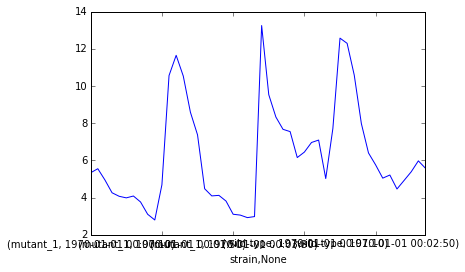

time: 195 ms


In [77]:
resampled_groups['angularspeed'].plot()

That doesn't look right... its plotting them on the same plot, but one after another and they are the same colour...

To plot a grouped data frame you need to loop over the groupby object and then resample and plot each group within the loop:

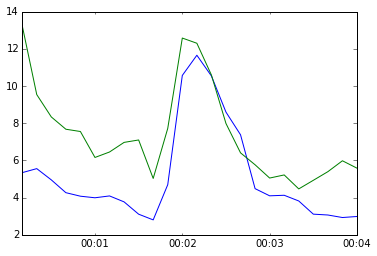

time: 583 ms


In [136]:
## loop over grouby object, and resample and plot each
for groups in grouped_behav:
    groups[1].resample('10s', how=('mean'))['angularspeed'].plot()    

## Summary

Pandas is a extremely useful and efficient tool for scientists, or anyone who needs to wrangle, analyze and visualize data!

#### Pandas is particularly attractive to scientists with minimal programming experience because:
* Strong, welcoming and growing community
* It is readable
* Idiom matches intuition

To learn more about Pandas see:
* [Pandas Documentation](http://pandas.pydata.org/)
* ipython notebook [tutorial](http://nsoontie.github.io/2015-03-05-ubc/novice/python/Pandas-Lesson.html) by Nancy Soontiens (Software Carpentry)
* Video [tutorial](https://www.youtube.com/watch?v=0CFFTJUZ2dc&list=PLYx7XA2nY5Gcpabmu61kKcToLz0FapmHu&index=12) from SciPy 2015 by Jonathan Rocher 
* [History of Pandas](https://www.youtube.com/watch?v=kHdkFyGCxiY) by Wes McKinney